Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .
2. Оцените ошибку модели из п.1 .

3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from sklearn.ensemble import GradientBoostingRegressor

In [2]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


C:\Users\sych_\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


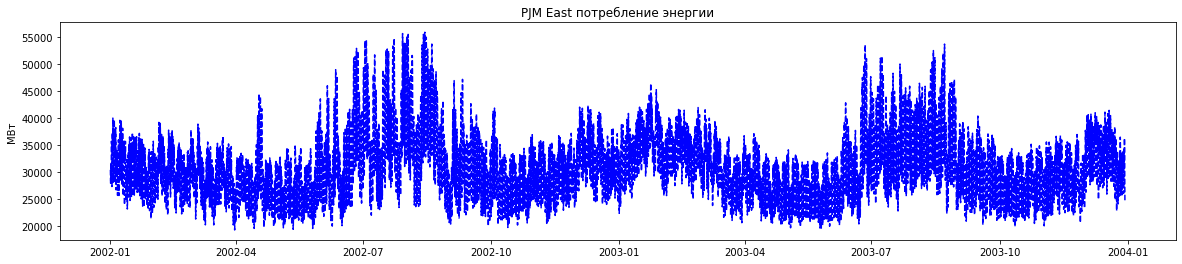

In [4]:
date_time =data['PJME_MW']
date_time.index = pd.date_range(data.index[0], periods=data.index.shape[0], freq="H")
plt.figure(figsize =(20,4))
plt.plot( date_time.index[:24*7*104], date_time.values[:24*7*104], '--b' )

plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

первая разность (x(t)-x(t-1))

In [3]:
d_data = data['PJME_MW'].values[1:]-data['PJME_MW'].values[:-1]

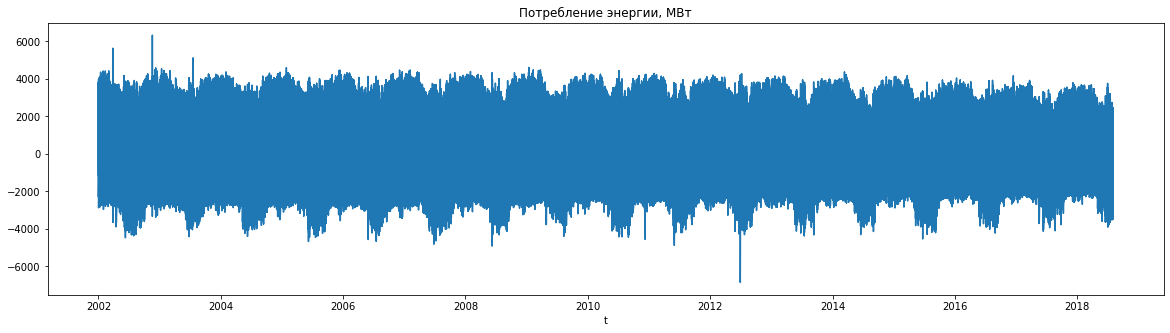

In [7]:
plt.figure(figsize=(20,5))
plt.plot(data.iloc[:-1].index,d_data)
plt.xlabel('t')
plt.title('Потребление энергии, МВт')
plt.show()

In [10]:
DF_data_d = sm.tsa.stattools.adfuller(d_data,regression='ctt')
DF_data_d

(-54.35201523870941,
 0.0,
 74,
 145298,
 {'1%': -4.371209756407774,
  '5%': -3.8324306460238056,
  '10%': -3.553285187108092},
 2092475.578853723)

In [11]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [12]:
d_data=data.resample('D').mean()

Text(0.5, 1.0, 'PJME_MW')

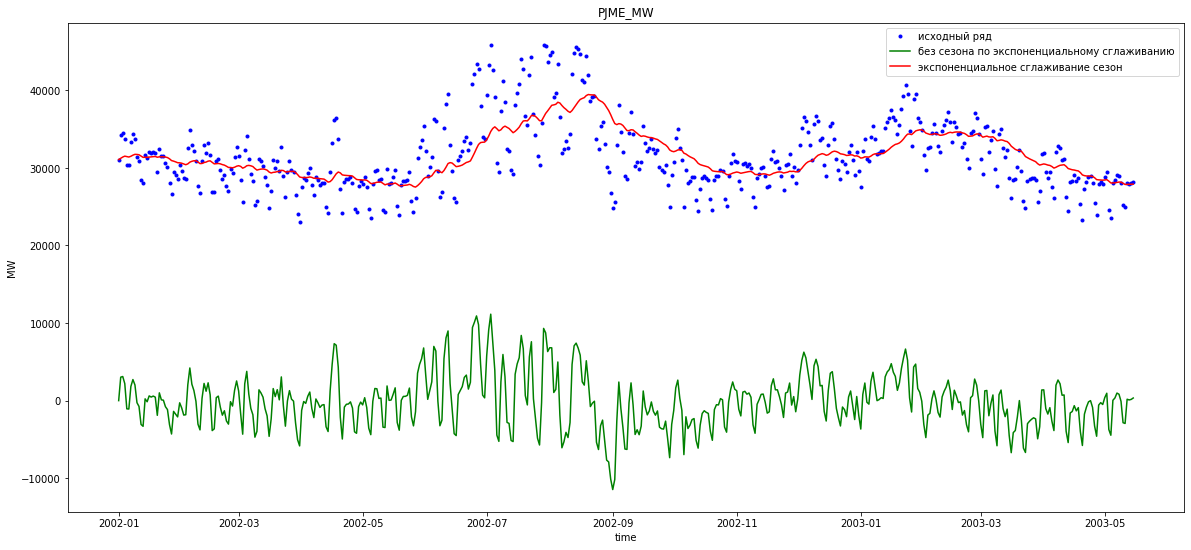

In [13]:
data_exp_1 = exponential_smoothing(d_data['PJME_MW']  , 0.05)
plt.figure(figsize=(20, 9))
plt.plot(d_data.index[:500], d_data['PJME_MW'].values[:500], '.b',label='исходный ряд')

plt.plot(d_data.index[:500],d_data['PJME_MW'].values[:500] - data_exp_1[:500] , color = 'green', label="без сезона по экспоненциальному сглаживанию");

plt.plot(d_data.index[:500],data_exp_1[:500] , color = 'red', label="экспоненциальное сглаживание сезон");

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')

In [16]:
df= pd.DataFrame(data_exp_1, index = d_data.index)
df.head()
 # добавили историю на глубину 3 измерения от текущего (р=3)
df['t'] = 0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0
df.iloc[3:,3]=df.iloc[:-3,0].values
df.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
df['exp_0_01'] = exponential_smoothing(df[0], 0.01)
df['exp_0_03'] = exponential_smoothing(df[0], 0.03)
df['exp_0_08'] = exponential_smoothing(df[0], 0.08)
# добавим разности - 1-й порядок
df['diff1'] = 0
df['diff1'].iloc[1:] = df.iloc[:-1,0]-df.iloc[1:,0]


df.head()

,0,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1
Date,,,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,31080.739130,31080.739130,31080.739130,0.0
2002-01-02,31239.779257,31080.739130,0.000000,0.000000,31082.329532,31085.510334,31093.462341,0.0
2002-01-03,31403.384044,31239.779257,31080.739130,0.000000,31085.540077,31095.046546,31118.256077,0.0
2002-01-04,31518.987759,31403.384044,31239.779257,31080.739130,31089.874554,31107.764782,31150.314611,0.0
2002-01-05,31463.294621,31518.987759,31403.384044,31239.779257,31093.608754,31118.430677,31175.353012,0.0


In [22]:
# сделаем примеры и модель 
def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

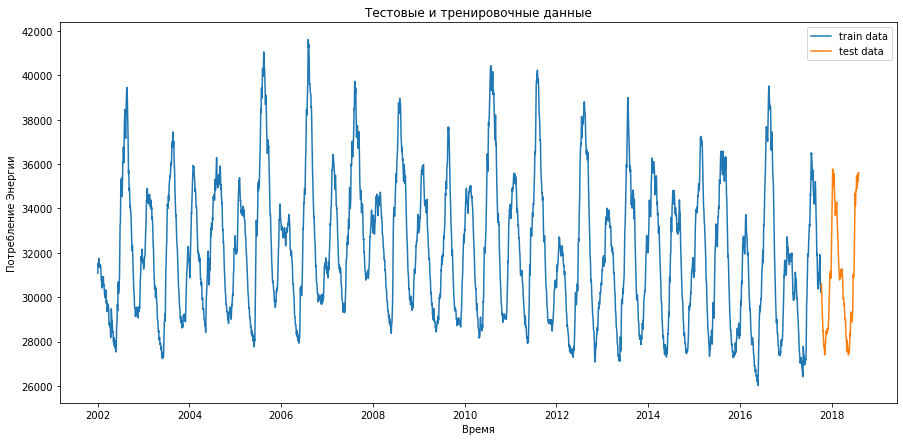

In [24]:
train_b, test_b = split_data_b( df, '10-10-2017')

X_train_b = train_b.iloc[:-1,:]
y_train_b = train_b[df.columns[0]].values[1:]
X_test_b = test_b.iloc[:-1,:]
y_test_b = test_b[df.columns[0]].values[1:]


plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление Энергии')
plt.plot(train_b.index.get_level_values('Date'),train_b[df.columns[0]], label='train data' )
plt.plot(test_b.index.get_level_values('Date'),test_b[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [18]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

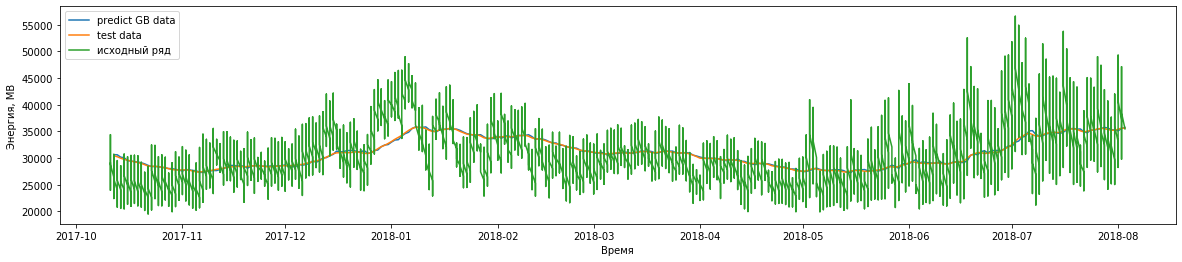

ошибка градиентного бустинга :   0.4536011762843374 %


In [26]:
model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Энергия, МВ')
plt.plot(test_b.index[1:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[1:],y_test_b, label='test data')
plt.plot(data.loc['2017-10-11':].index, data.loc['2017-10-11':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

Модель авторегрессии с горизонтом прогноза 1 (т.е. считаем на один шаг вперед) работает замечательно на всем интервале теста. Значение ошибки для нее не превышает 0.45%. 

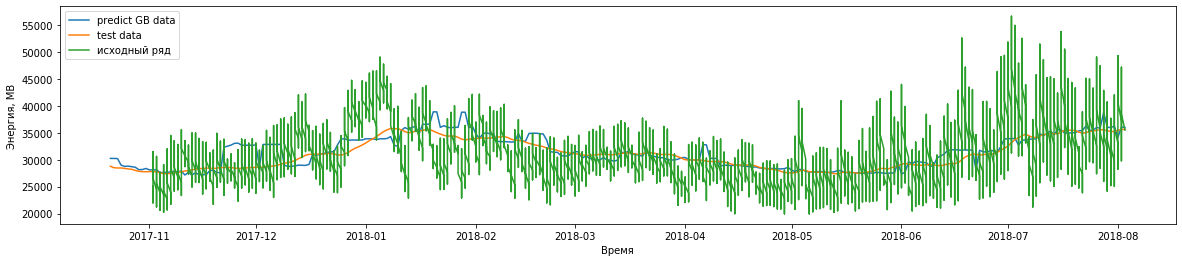

ошибка градиентного бустинга :   3.2711580175524215 %


In [29]:
h=10
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[0]].values[h:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Энергия, МВ')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.plot(data.loc['2017-11-02':].index, data.loc['2017-11-02':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

 Очевидно, все стало не так хорошо (3.27% ошибки по основной линии прогноза и много по реальному ряду)

4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

а) Изменение температуры за окном :).

б) Количество денег, которые тратят покупатели в интернет магазине.

в) Вес растущего котенка.

г) Прирост объема деревьев в лесу от времени

а) ряд не стационарный, имеет тренд, сезон и цикл. Температура за окном зависит от времени года, ближе к лету повышается, ближе к зиме понижается, каждый год ситуация повторяется.

б) ряд не стационарный, имеет тренд, сезон и цикл. Например, ближе к праздникам количество покупок увеличивается, на выходных покупают больше товара, товар сам по себе может быть сезонным, одычно каждый год ситуация повторяется. 

в) ряд не стационарный, имеет тренд. Вес котенка будет постепенно увеличиваться, пока не достигнет какого то плато.

г) возможно это будет стационарный ряд, какие то деревья выростают, какие то падают под влиянием стихии. В среднем их количество одинаково и разброс значений сильно не меняется.